In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns
import pandas as pd

from scipy.optimize import minimize
import scipy.io as sio
import math

sns.set_context('notebook')
#sns.set_style('white')
plt.style.use('fivethirtyeight') # blue
#plt.style.use('ggplot') # red
plt.xkcd() # because why not?
np.set_printoptions(precision=3)
np.seterr(divide='ignore', invalid='ignore') # Ignore divide by zero

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [120]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, L, iterating=False):
    X = params[:num_movies*num_features].reshape((num_movies, num_features))
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    
    row_sub, col_sub = np.where(R)
    
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    
    X_mat = X[row_sub, :]
    Theta_mat = Theta[col_sub, :]
    
    cost_mat = np.sum(X_mat * Theta_mat, 1) - Y[row_sub, col_sub]
    J = 1/2 * (cost_mat.T @ cost_mat)
    
    # Regularization
    J += L/2 * (np.sum(Theta ** 2) + np.sum(X ** 2));

    # Determining the gradient
    for i in range(num_movies):
        idx = np.where(R[i, :] == 1)
        Theta_temp = Theta[idx]
        Y_temp = Y[i, idx]
        X_grad[i, :] = (X[i:i+1, :] @ Theta_temp.T - Y_temp) @ Theta_temp + L * X[i, :]
    
    for j in range(num_users):
        idy = np.where(R[:, j] == 1)
        Theta_temp = Theta[j:j+1, :]
        Y_temp = Y[idy, j]
        X_temp = X[idy]
        Theta_grad[j, :] = (Theta_temp @ X_temp.T  - Y_temp) @ X_temp + L * Theta[j, :]

    # Flatten gradient
    grad = np.append(X_grad.flatten(), Theta_grad.flatten())
    
    if iterating: print('Cost: {}'.format(J))
        
    return J, grad

In [4]:
def computeNumericalGradient(costFunc, theta):
    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    epsilon = 1e-4

    for p in range(theta.size):
        perturb[p] = epsilon
        loss1, _ = costFunc(theta - perturb)
        loss2, _ = costFunc(theta + perturb)
        
        numgrad[p] = (loss2 - loss1) / (2*epsilon)
        perturb[p] = 0
    
    return numgrad
    
def checkCostFunction(L):
    # Create a random problem
    
    X_t = np.random.rand(4, 3)
    Theta_t = np.random.rand(5, 3)
    
    # Remove entries
    Y = X_t @ Theta_t.T
    Y[np.random.rand(*Y.shape) > 0.5] = 0
    R = np.zeros(Y.shape)
    R[Y != 0] = 1
    
    # Gradient checking
    X = np.random.randn(*X_t.shape)
    Theta = np.random.randn(*Theta_t.shape)
    num_movies, num_users = Y.shape
    num_features = Theta_t.shape[1]
    
    cost, grad = cofiCostFunc(np.append(X.flatten(), Theta.flatten()), \
                              Y, R, num_users, num_movies, num_features, L) 
    
    costFunc = lambda t: cofiCostFunc(t, Y, R, num_users, num_movies, num_features, L)
    
    numgrad = computeNumericalGradient(costFunc, np.append(X.flatten(), Theta.flatten()))
    
    print('Numerical Gradient, Gradient')
    print(np.vstack((grad, numgrad)).T)

In [5]:
def normalizeRatings(Y, R):
    m, n = Y.shape
    mu = np.zeros((m, 1))
    norm = np.zeros(Y.shape)
    
    for i in range(m):
        idx = np.where(R[i, :] == 1)
        mu[i] = np.mean(Y[i,idx])
        norm[i, idx] = Y[i, idx] - mu[i];
        
    return mu, norm

In [6]:
data = sio.loadmat('ex8_movies.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [7]:
Y = data['Y']
R = data['R']

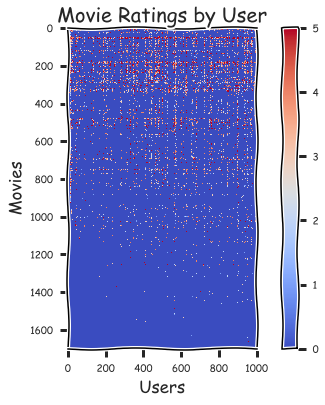

In [8]:
plt.figure()
plt.imshow(Y, extent=[0, 1000, 1700, 0], cmap=cm.coolwarm)
plt.colorbar()

plt.title('Movie Ratings by User')
plt.xlabel('Users')
plt.ylabel('Movies')

In [9]:
data = sio.loadmat('ex8_movieParams.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])

In [10]:
X = data['X']
Theta = data['Theta']
num_users = data['num_users']
num_movies = data['num_movies']
num_features = data['num_features']

In [11]:
# Reduce data size so training runs faster

num_users = 4; num_movies = 5; num_features = 3;
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

params = np.append(X.flatten(), Theta.flatten())

In [12]:
J, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 0);

In [13]:
checkCostFunction(1.5)

Numerical Gradient, Gradient
[[ 30.239  30.239]
 [-18.318 -18.318]
 [-10.405 -10.405]
 [  1.467   1.467]
 [  1.463   1.463]
 [ -1.113  -1.113]
 [  1.132   1.132]
 [ -2.102  -2.102]
 [ -0.65   -0.65 ]
 [  1.743   1.743]
 [ -0.345  -0.345]
 [ -1.006  -1.006]
 [ -9.539  -9.539]
 [  4.682   4.682]
 [  3.52    3.52 ]
 [ -6.803  -6.803]
 [  2.738   2.738]
 [  2.266   2.266]
 [ 18.977  18.977]
 [-10.905 -10.905]
 [ -4.906  -4.906]
 [-12.109 -12.109]
 [  7.53    7.53 ]
 [  3.506   3.506]
 [  0.847   0.847]
 [ -1.04   -1.04 ]
 [  1.413   1.413]]


In [14]:
df = pd.read_table('test.txt', names=['Movie'])

In [15]:
_, df['Movie'] = df['Movie'].str.split(' ', 1).str
df['Movie'], df['Year'] = df['Movie'].str.rsplit(' ', 1).str
df['Year'] = df['Year'].str.replace(r'\(|\)', '')

In [16]:
df.head()

,Movie,Year
0,Toy Story,1995
1,GoldenEye,1995
2,Four Rooms,1995
3,Get Shorty,1995
4,Copycat,1995


In [113]:
n = 1682
ratings = np.zeros((n, 1))

# Inputted ratings for movies
ratings[0] = 4
ratings[97] = 2
ratings[6] = 3
ratings[11]= 5
ratings[53] = 4
ratings[63]= 5
ratings[65]= 3
ratings[68] = 5
ratings[182]= 4
ratings[225] = 5
ratings[354]= 5

for i in range(len(ratings)):
    if ratings[i].item():
        print('Rated {} for {}'.format(ratings[i].item(), df['Movie'][i]))

Rated 4.0 for Toy Story
Rated 3.0 for Twelve Monkeys
Rated 5.0 for Usual Suspects, The
Rated 4.0 for Outbreak
Rated 5.0 for Shawshank Redemption, The
Rated 3.0 for While You Were Sleeping
Rated 5.0 for Forrest Gump
Rated 2.0 for Silence of the Lambs, The
Rated 4.0 for Alien
Rated 5.0 for Die Hard 2
Rated 5.0 for Sphere


In [114]:
data = sio.loadmat('ex8_movies.mat');
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [115]:
Y = data['Y']
R = data['R']

# Add our personal data
Y = np.hstack((ratings, Y))
R = np.hstack((ratings != 0, R))

num_movies, num_users = Y.shape
num_features = 10

In [116]:
# Normalize ratings
Y_mean, Y_norm = normalizeRatings(Y, R)

X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.append(X.flatten(), Theta.flatten())

In [121]:
L = 10
iteration = 0

costFunc = lambda t: cofiCostFunc(t, Y_norm, R, num_users, num_movies, num_features, L, iterating=True)
res = minimize(costFunc,
               x0=initial_parameters,
               method='CG',
               jac=True,
               options={'maxiter':100})

Cost: 694364.843134783
Cost: 694364.843134783
Cost: 673236.0265312926
Cost: 595137.5628084885
Cost: 370438.06506344036
Cost: 196971.02123853262
Cost: 3693237.21589428
Cost: 121600.18393455731
Cost: 109775.37051166159
Cost: 92069.78459417206
Cost: 90344.15991230158
Cost: 76276.82023416957
Cost: 69652.00051422622
Cost: 61492.1448387611
Cost: 59948.734562110454
Cost: 57617.177219280486
Cost: 52956.748277449944
Cost: 47360.6590201214
Cost: 45919.71231001893
Cost: 43997.76821730778
Cost: 45622.96562242422
Cost: 42408.32764817131
Cost: 42288.09057295728
Cost: 41536.82701575762
Cost: 41076.34222564797
Cost: 40922.69042007743
Cost: 40619.793079563
Cost: 40509.880722629816
Cost: 40305.539010592365
Cost: 40226.888607666704
Cost: 39968.936295793785
Cost: 39875.211867679725
Cost: 39804.76269930388
Cost: 39621.38545974534
Cost: 39488.602398193936
Cost: 39614.075162308334
Cost: 39439.6935936515
Cost: 39366.73063248969
Cost: 39344.25959357865
Cost: 39328.12572659596
Cost: 39291.13858080682
Cost: 3926

In [122]:
params = res['x']

X = params[:num_movies*num_features].reshape((num_movies, num_features))
Theta = params[num_movies*num_features:].reshape(num_users, num_features)

pred = X @ Theta.T
pred = pred[:, 1] + Y_mean.flatten()

ix = np.argsort(pred)[::-1]

In [123]:
for i in range(10):
    j = ix[i]
    print('Predicting rating {} for movie {}'.format(pred[j], df['Movie'][j]))

Predicting rating 5.760745026695732 for movie Star Wars
Predicting rating 5.33593128694247 for movie Empire Strikes Back, The
Predicting rating 5.282804165910463 for movie Return of the Jedi
Predicting rating 5.133603614664415 for movie Lawrence of Arabia
Predicting rating 5.112998513773848 for movie Monty Python and the Holy Grail
Predicting rating 5.083566657240322 for movie Wrong Trousers, The
Predicting rating 5.073822477297938 for movie Citizen Kane
Predicting rating 5.0000877786246125 for movie Great Day in Harlem, A
Predicting rating 5.0000622358649105 for movie Star Kid
Predicting rating 5.000002294962179 for movie Santa with Muscles


In [124]:
print('Original ratings provided: \n')
for i in range(len(ratings)):
    if ratings[i]:
        print('Rated {} for {}'.format(ratings[i].item(), df['Movie'][i]))

Original ratings provided: 

Rated 4.0 for Toy Story
Rated 3.0 for Twelve Monkeys
Rated 5.0 for Usual Suspects, The
Rated 4.0 for Outbreak
Rated 5.0 for Shawshank Redemption, The
Rated 3.0 for While You Were Sleeping
Rated 5.0 for Forrest Gump
Rated 2.0 for Silence of the Lambs, The
Rated 4.0 for Alien
Rated 5.0 for Die Hard 2
Rated 5.0 for Sphere
